In [2]:
import os

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import keras
import matplotlib.pyplot as plt 
import numpy as np 


The idea is to train an AI to effectively upscale an 8x8 image to a 32x32 image, obviously this could be extended to higher resolutions but for ease of training data this is done here. To do this we will use Keras' built in CIFAR100 dataset, we dont intend to perform classification here and instead will use the training data as the sample outputs data and produce new training data from this. 

Each given imagine in the CIFAR100 set is a 3x32x32, firstly we will only look to upscale a greyscale imagine and then apply this techinque again to the 3 channels later. So we will convert each of these images into a 32x32 array of values from 0-1 then proceed to downscale to 8x8 and then apply mild noise then reclamp the values to 0-1. The intent to add noise is to avoid overfitting to this data.

In [3]:
(train_samples, y_train), (test_samples, y_test) = keras.datasets.cifar100.load_data(label_mode="fine")

169009152/169001437 [==============================] - 59s 0us/step


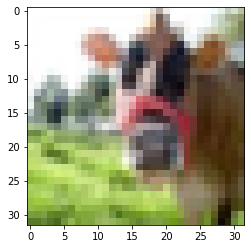

In [5]:
plt.imshow(train_samples[0])

In [6]:
print(train_samples[0].shape)

(32, 32, 3)


In [24]:
# Colour weights for the greyscale
colour_weights = [0.2989, 0.5870, 0.1140]

# greyscale image
def greyscale(c_img):
    return np.dot(c_img[...,:3], colour_weights)/255

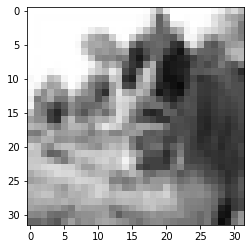

In [27]:
plt.imshow(greyscale(train_samples[0]),cmap='gray', vmin=0, vmax=1)

In [47]:
# downscales the image by ratio, image dimensions must be divisible by ratio
def downscale(f_img, ratio=2):
    f_x, f_y = f_img.shape

    n_x = f_x // ratio
    n_y = f_y // ratio

    img = np.zeros((n_x, n_y))

    for x in range(0, n_x):
        for y in range(0, n_y):
            img[x,y] += f_img[2 * x, 2 * y]
            img[x,y] += f_img[2 * x + 1, 2 * y]
            img[x,y] += f_img[2 * x, 2 * y + 1]
            img[x,y] += f_img[2 * x + 1, 2 * y + 1]
            img[x,y] /= 4

    return img

downscaled_samples = []
for sample in train_samples[:500]:
    downscaled_samples.append(downscale(greyscale(sample)))

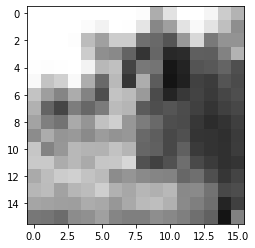

In [48]:
plt.imshow(downscaled_samples[0],cmap='gray', vmin=0, vmax=1)

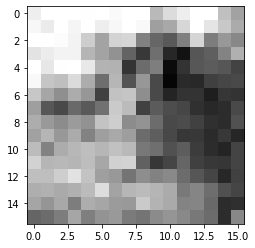

In [153]:
def add_noise(img, noise_amp=0.05):
    # add the noise
    out_img = img + np.random.normal(scale=noise_amp, size=img.shape)
    # clamp to range
    out_img[out_img > 1] = 1
    out_img[out_img < 0] = 0

    return out_img

plt.imshow(add_noise(downscaled_samples[0]),cmap='gray', vmin=0, vmax=1)

So we can now create the training data, lets produce a set of 2000 images to train on.

In [162]:
def create_training_images(sample_images, ratio=2, noise=0.01):
    training_images = np.array([add_noise(downscale(greyscale(sample), ratio=ratio), noise_amp=noise) for sample in sample_images])
    true_images = np.array([greyscale(sample) for sample in sample_images])

    return (training_images[...,np.newaxis], true_images[...,np.newaxis])

sample_num = 20000
training_images, true_images = create_training_images(train_samples[:sample_num])

We now introduce the model, the idea is to upscale in 2 steps, firstly to the target resolution and then have a sharpening layer.
down-img -> conv2d layer(same dim as down_img) -> dense layer (same dim as output img) -> conv2d (same dim as output image) -> dense (same dim as output image) -> output reshape.

The loss is straighforward and will just be the MSE.

In [159]:
input_shape = (16,16,1)
output_shape = (32, 32, 1)
input_total = 16 * 16
output_total = 32 * 32

model = keras.Sequential()
model.add(keras.layers.Conv2D(1,4,padding='same', input_shape=input_shape))
model.add(keras.layers.Dense(output_total * 4))
model.add(keras.layers.Conv2D(1,4,padding='same', input_shape=output_shape))
model.add(keras.layers.Flatten())
# 'sharpening layer'
model.add(keras.layers.Dense(output_total * 4))
model.add(keras.layers.Dropout(.1))
model.add(keras.layers.Dense(output_total))
model.add(keras.layers.Reshape(output_shape))
model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 16, 16, 1)         17        
_________________________________________________________________
dense_57 (Dense)             (None, 16, 16, 4096)      8192      
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 16, 16, 1)         65537     
_________________________________________________________________
flatten_15 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 4096)              1052672   
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_59 (Dense)             (None, 1024)              4195328   
__________

In [160]:
model.fit(x=training_images, y=true_images, batch_size=16, epochs=2)

Epoch 1/2
20000/20000 [==============================] - 60s 3ms/step - loss: 0.0099
Epoch 2/2
20000/20000 [==============================] - 58s 3ms/step - loss: 0.0045


Lets see how it performs, here is a selection of in-sample images

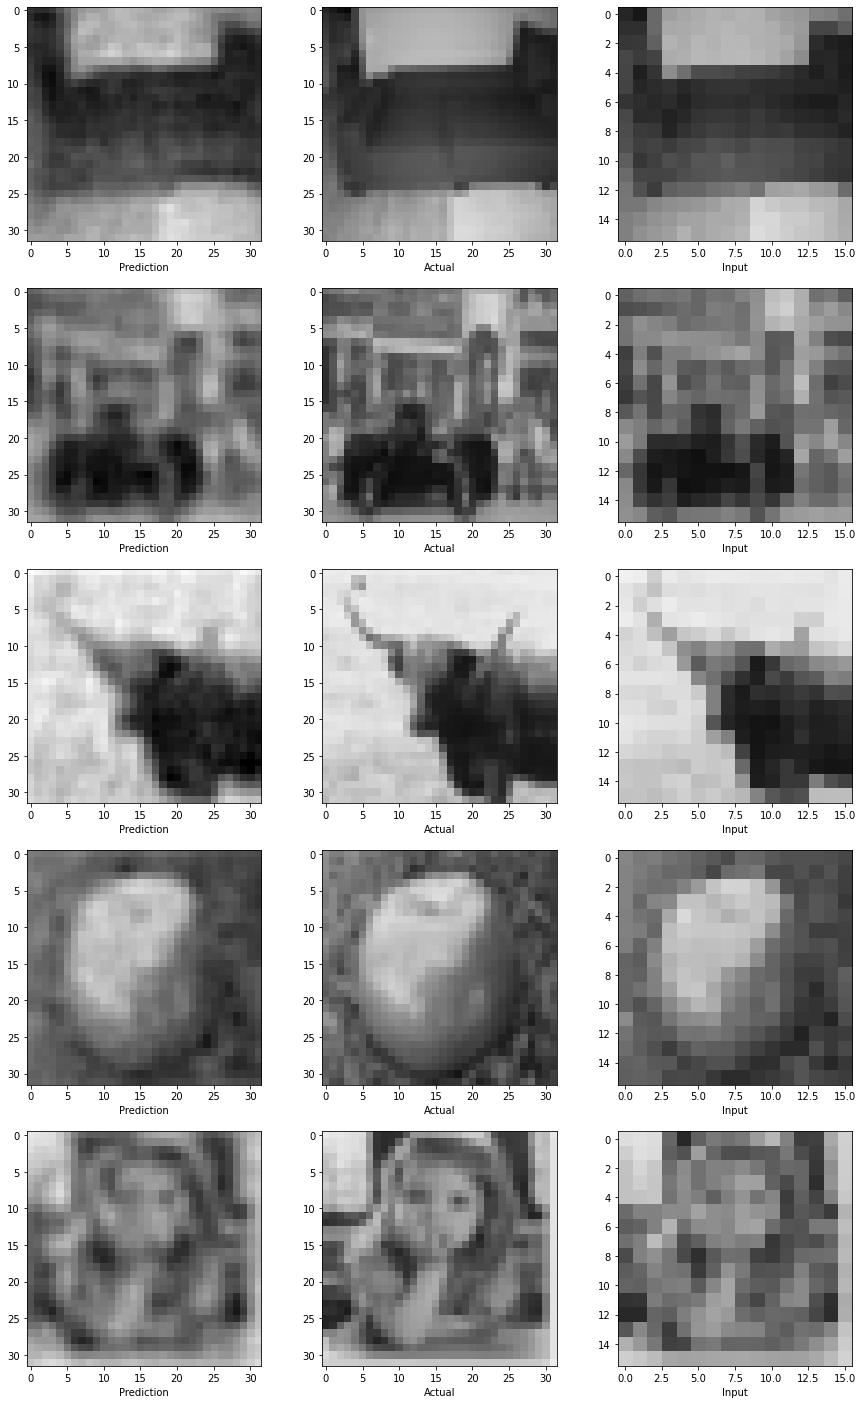

In [176]:
sample_indexs = np.random.randint(sample_num, size=5)
training_samples = training_images[sample_indexs]
predictions = model.predict(training_samples)
# losses = model.evaluate(training_samples, true_images[sample_indexs])
index = 1
plt.figure(figsize=(15,25))
for (prediction, sample, image) in zip(predictions, training_samples, true_images[sample_indexs]):
    plt.subplot(5,3,index)
    index += 1
    plt.xlabel('Prediction')
    plt.imshow(prediction,cmap='gray', vmin=0, vmax=1)
    plt.subplot(5,3,index)
    index += 1
    plt.xlabel('Actual')
    plt.imshow(image,cmap='gray', vmin=0, vmax=1)
    plt.subplot(5,3,index)
    index += 1
    plt.xlabel('Input')
    plt.imshow(sample, cmap='gray', vmin=0, vmax=1)